In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# 1) Дані: CIFAR-10 (скачується автоматично з оф. джерела)
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()  # 50k train, 10k test, 10 класів
num_classes = 10

# Перетворення типів
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
y_train = y_train.squeeze()
y_test  = y_test.squeeze()

In [5]:
# 2) Аугментації (on-the-fly)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
])


In [6]:
# 3) Модель: сучасний «плотний» CNN з BatchNorm
def make_model():
    inputs = keras.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs)

    def conv_block(x, f, k=3, p=True):
        x = layers.Conv2D(f, k, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        if p:
            x = layers.Conv2D(f, k, padding="same", use_bias=False)(x)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)
        x = layers.MaxPooling2D()(x)
        return x

    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)

    x = layers.Dropout(0.4)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

model = make_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 8, 8, 256)      │             

 Total params: 1,216,458 (4.64 MB)

 Trainable params: 1,214,666 (4.63 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [7]:
# 4) Колбеки: найкраща модель + зменшення LR + рання зупинка
callbacks = [
    keras.callbacks.ModelCheckpoint("best_cifar10.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1, min_lr=1e-5),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

In [8]:
# 5) Тренування
history = model.fit(
    x_train, y_train,
    epochs=40,                # можна підняти для кращої якості, час не критичний
    batch_size=128,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 323s 863ms/step - accuracy: 0.4092 - loss: 1.6095 - val_accuracy: 0.2778 - val_loss: 2.1970 - learning_rate: 0.0010
Epoch 2/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 248s 704ms/step - accuracy: 0.5714 - loss: 1.1964 - val_accuracy: 0.5216 - val_loss: 1.3945 - learning_rate: 0.0010
Epoch 3/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 246s 699ms/step - accuracy: 0.6414 - loss: 1.0153 - val_accuracy: 0.4218 - val_loss: 2.1348 - learning_rate: 0.0010
Epoch 4/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 244s 692ms/step - accuracy: 0.6902 - loss: 0.8962 - val_accuracy: 0.6372 - val_loss: 1.1677 - learning_rate: 0.0010
Epoch 5/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 246s 698ms/step - accuracy: 0.7230 - loss: 0.8089 - val_accuracy: 0.6442 - val_loss: 1.1860 - learning_rate: 0.0010
Epoch 6/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 246s 700ms/step - accuracy: 0.7454 - loss: 0.7450 - val_accuracy: 0.6752 - val_loss: 1.0810 - learning_rate: 0.0010
Epoch 7/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 243s 689ms/step - accura

In [9]:
# 6) Оцінка на тесті
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}  |  Test Acc: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8582 - loss: 0.4382
Test Loss: 0.4382  |  Test Acc: 0.8582


In [10]:
# 7) Детальний звіт і матриця плутанини
y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0     0.8588    0.8880    0.8732      1000
           1     0.8963    0.9590    0.9266      1000
           2     0.7969    0.8320    0.8141      1000
           3     0.7640    0.7220    0.7424      1000
           4     0.8612    0.8250    0.8427      1000
           5     0.8481    0.7480    0.7949      1000
           6     0.8208    0.9300    0.8720      1000
           7     0.8867    0.8920    0.8893      1000
           8     0.9709    0.8690    0.9172      1000
           9     0.8877    0.9170    0.9021      1000

    accuracy                         0.8582     10000
   macro avg     0.8591    0.8582    0.8574     10000
weighted avg     0.8591    0.8582    0.8574     10000

[[888  12  36  12  10   1   4   9  11  17]
 [  4 959   0   1   0   0   1   1   2  32]
 [ 30   3 832  25  32  23  38  12   0   5]
 [ 16  10  38 722  38  67  64  26   5  14]
 [  5   1  47  24 825  15  52  29   1   1]
 [  5   3  30 121  26 748 

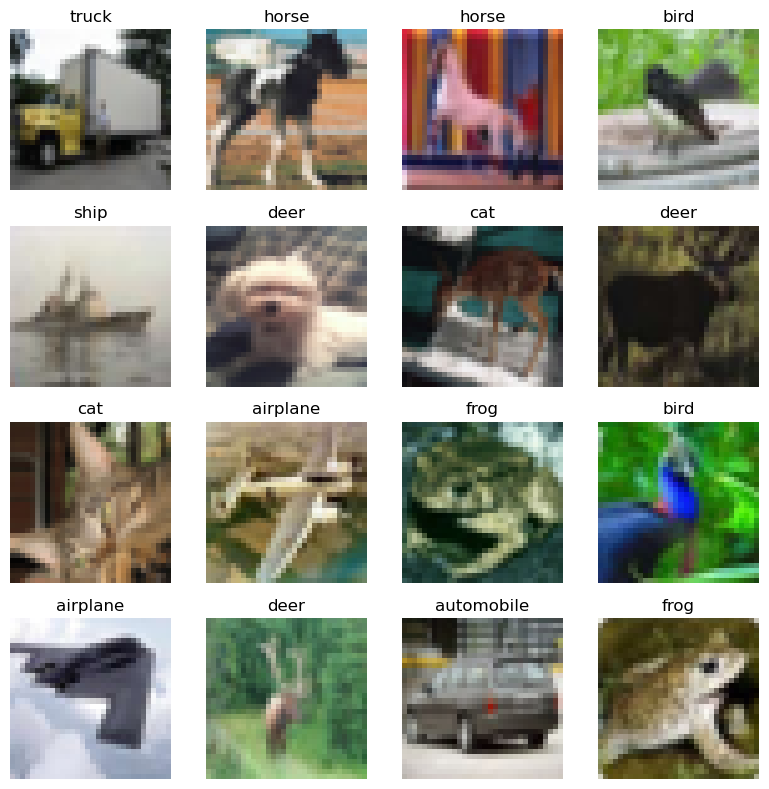

In [11]:
# 8) Приклад інференсу та візуалізації
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
idx = np.random.choice(len(x_test), 16, replace=False)
imgs = x_test[idx]
preds = np.argmax(model.predict(imgs, verbose=0), axis=1)

plt.figure(figsize=(8,8))
for i,(img,pr) in enumerate(zip(imgs,preds)):
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(class_names[pr])
plt.tight_layout()
plt.show()

Result: bird (probability 0.99)


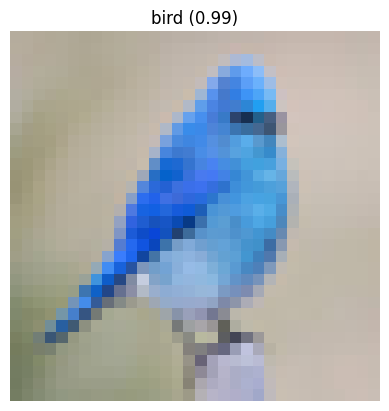

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# Класи CIFAR-10
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

# 1) Завантажуємо збережену модель
model = keras.models.load_model("best_cifar10.keras")

# 2) Функція для підготовки картинки
def prepare_image(img_path):
    # Відкрити зображення
    img = Image.open(img_path).convert("RGB")
    # CIFAR-10 має 32x32, тому ресайз
    img = img.resize((32, 32))
    # Перетворення в numpy масив
    img_array = np.array(img).astype("float32") / 255.0
    # Додати вимір batch (1, 32, 32, 3)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

# 3) Прогноз
img_array, orig_img = prepare_image("bird.jpg")   # заміни на свій шлях
pred = model.predict(img_array, verbose=0)
class_id = np.argmax(pred)
confidence = pred[0][class_id]

print(f"Result: {class_names[class_id]} (probability {confidence:.2f})")

# Відображення фото
plt.imshow(orig_img)
plt.axis("off")
plt.title(f"{class_names[class_id]} ({confidence:.2f})")
plt.show()


In [8]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# Класи CIFAR-10
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

# Завантажуємо модель
model = keras.models.load_model("best_cifar10.keras")

# Функція підготовки зображення
def prepare_image(img_path):
    orig = Image.open(img_path).convert("RGB")
    resized = orig.resize((32, 32), Image.LANCZOS)
    arr = np.array(resized).astype("float32") / 255.0
    arr = np.expand_dims(arr, axis=0)  # (1,32,32,3)
    return arr, orig

# Функція відкриття і предикції
def open_image():
    file_path = filedialog.askopenfilename(
        filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.bmp")]
    )
    if not file_path:
        return

    # Проганяємо через модель
    x, orig = prepare_image(file_path)
    pred = model.predict(x, verbose=0)[0]
    class_id = int(np.argmax(pred))
    conf = float(pred[class_id])

    # Показуємо оригінальне фото в GUI
    orig_resized = orig.resize((200, 200))  # щоб влізло в вікно
    img_tk = ImageTk.PhotoImage(orig_resized)

    panel.config(image=img_tk)
    panel.image = img_tk

    # Виводимо результат
    label_var.set(f"Class: {class_names[class_id]} ({conf:.2f})")

# --- GUI ---
root = tk.Tk()
root.title("CIFAR-10 Image Classifier")

btn = tk.Button(root, text="Select image", command=open_image, font=("Arial", 12))
btn.pack(pady=10)

panel = tk.Label(root)
panel.pack()

label_var = tk.StringVar()
label = tk.Label(root, textvariable=label_var, font=("Arial", 14))
label.pack(pady=10)

root.mainloop()
